# INSY336 Social Speculation for Harnessing Reddit to Forecast Bitcoin Fluctuations

## Model Implementation

In [2]:
# importing needed packages
import requests
import sqlite3
import pandas as pd
import plotly.express as px

In [22]:
# Connect to the database
conn = sqlite3.connect("reddit.db")

In [24]:
# Read reddit posts from database
posts_df = pd.read_sql('select * from posts', conn)
posts_df.head()

,id,title,score,ups,downs,upvote_ratio,url,num_comments,created,body,sentiment,subjectivity
0,1gb50uu,Sparrow wallet desktop vs blue wallet mobile app,2,2,0,0.75,https://www.reddit.com/r/btc/comments/1gb50uu/...,1,2024-10-24,"Looking into which option is safer, from what ...",0.250000,0.525000
1,1gazksu,Medium of exchange is the most essential prope...,26,26,0,0.84,https://x.com/MKjrstad/status/1849388107449209110,26,2024-10-24,,NaN,NaN
2,1gayaq2,Beige Book’s Sluggish Signals (📉 U.S. Economy ...,0,0,0,0.36,https://i.redd.it/4h0pcfss4owd1.png,0,2024-10-24,,NaN,NaN
3,1gaww3g,Bitcoin Breakout Or Fakeout,0,0,0,0.35,https://i.redd.it/ujtnz7ptnnwd1.jpeg,9,2024-10-24,10/24/2024 3:15 AM Quick #Bitcoin Update! 🕒💥\n...,0.177083,0.390625
4,1gawveo,Denmark Proposes 42% Tax on Unrealized Crypto ...,16,16,0,0.75,https://coinradar.news/article/3WHFngG8xcIkKfz...,30,2024-10-24,,NaN,NaN


In [25]:
#drop na for empty posts
posts_df = posts_df.dropna()

In [26]:
# Read crypto prices from database
crypto_df = pd.read_sql('select * from crypto',conn)

# Calculate daily returns
crypto_df['daily_returns'] = crypto_df['close'].pct_change()
crypto_df

,symbol,date,close,daily_returns
0,BTC,2024-10-25,62812.08,NaN
1,BTC,2024-10-24,62976.58,0.002619
2,BTC,2024-10-23,61791.39,-0.018820
3,BTC,2024-10-22,62400.56,0.009858
4,BTC,2024-10-21,62154.91,-0.003937
...,...,...,...,...
345,BTC,2023-11-15,34916.07,0.047079
346,BTC,2023-11-14,32706.47,-0.063283
347,BTC,2023-11-13,34106.01,0.042791
348,BTC,2023-11-12,34720.75,0.018024


In [220]:
# Close connection
conn.close()

In [27]:
# change col name
posts_df.columns = ['id', 'title', 'score', 'ups', 'downs', 'upvote_ratio', 'url',
       'num_comments', 'date', 'body', 'sentiment', 'subjectivity']

In [28]:
# check the earliest date
pd.to_datetime(posts_df['date']).min()

Timestamp('2024-07-22 00:00:00')

In [29]:
# aggregate df by mean per day
posts_df_agg = posts_df.groupby('date')[['score','ups','downs','upvote_ratio','num_comments', 'sentiment', 'subjectivity']].agg('mean').reset_index()

In [30]:
# add days of week feature
posts_df_agg['day_of_week'] = pd.to_datetime(posts_df_agg['date']).dt.dayofweek


In [31]:
# check df
posts_df_agg.head()

,date,score,ups,downs,upvote_ratio,num_comments,sentiment,subjectivity,day_of_week
0,2024-07-22,0.0,0.0,0.0,0.350000,16.000000,0.100000,0.580000,0
1,2024-07-23,3.0,3.0,0.0,0.525000,9.000000,0.013068,0.447159,1
2,2024-07-24,10.0,10.0,0.0,0.466667,13.333333,-0.011905,0.338889,2
3,2024-07-25,5.0,5.0,0.0,0.645000,9.000000,0.144152,0.364208,3
4,2024-07-26,18.0,18.0,0.0,0.736667,20.333333,0.179189,0.483967,4


In [32]:
# Merge dataframes on date

df = posts_df_agg.merge(crypto_df, on='date', how='inner')
df.head()

,date,score,ups,downs,upvote_ratio,num_comments,sentiment,subjectivity,day_of_week,symbol,close,daily_returns
0,2024-07-22,0.0,0.0,0.0,0.350000,16.000000,0.100000,0.580000,0,BTC,62030.69,0.020981
1,2024-07-23,3.0,3.0,0.0,0.525000,9.000000,0.013068,0.447159,1,BTC,60755.96,0.006994
2,2024-07-24,10.0,10.0,0.0,0.466667,13.333333,-0.011905,0.338889,2,BTC,60333.99,-0.005211
3,2024-07-25,5.0,5.0,0.0,0.645000,9.000000,0.144152,0.364208,3,BTC,60650.01,-0.030589
4,2024-07-26,18.0,18.0,0.0,0.736667,20.333333,0.179189,0.483967,4,BTC,62563.79,0.001213


In [33]:
# check shape
df.shape

(90, 12)

In [34]:
# Line plot of close
fig = px.line(df, x="date", y=["close"])
fig.show()

In [35]:
# Scatter plot of daily returns vs sentiment scores
fig = px.scatter(df, x="sentiment", y="close", width=800, height=800)
fig.show()

In [36]:
# Correlation matrix of daily returns, sentiment and subjectivity scores
corrmatrix = df[['close','sentiment','subjectivity']].corr()
corrmatrix

,close,sentiment,subjectivity
close,1.000000,0.057814,0.016310
sentiment,0.057814,1.000000,0.191788
subjectivity,0.016310,0.191788,1.000000


In [37]:
# Heatmap of correlation matrix
fig = px.imshow(corrmatrix)
fig.show()

In [44]:
# import model building packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from linear_model import LinearRegression
import matplotlib.pyplot as plt

In [164]:
# define X and y
X = df.drop(columns=['close','daily_returns','date','symbol'])
y = df['close']

In [208]:
# Get the index for splitting the data (80% training, 20% testing)
split_index = int(len(X) * 0.8)

# Split the data into training and testing sets sequentially
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [167]:
base_model = LinearRegression()
# train
base_model.fit(X_train,y_train)
# prediction
yh_train = base_model.predict(X_train)
yh_test = base_model.predict(X_test)

mse_train = mean_squared_error(y_pred=yh_train, y_true=y_train)
mse_test = mean_squared_error(y_pred=yh_test, y_true=y_test)

print(f'Train MSE for baseline model is {mse_train}')
print(f'Test MSE for baseline model is {mse_test}')


Train MSE for baseline model is 11037142.902018717
Test MSE for baseline model is 30448594.36820425


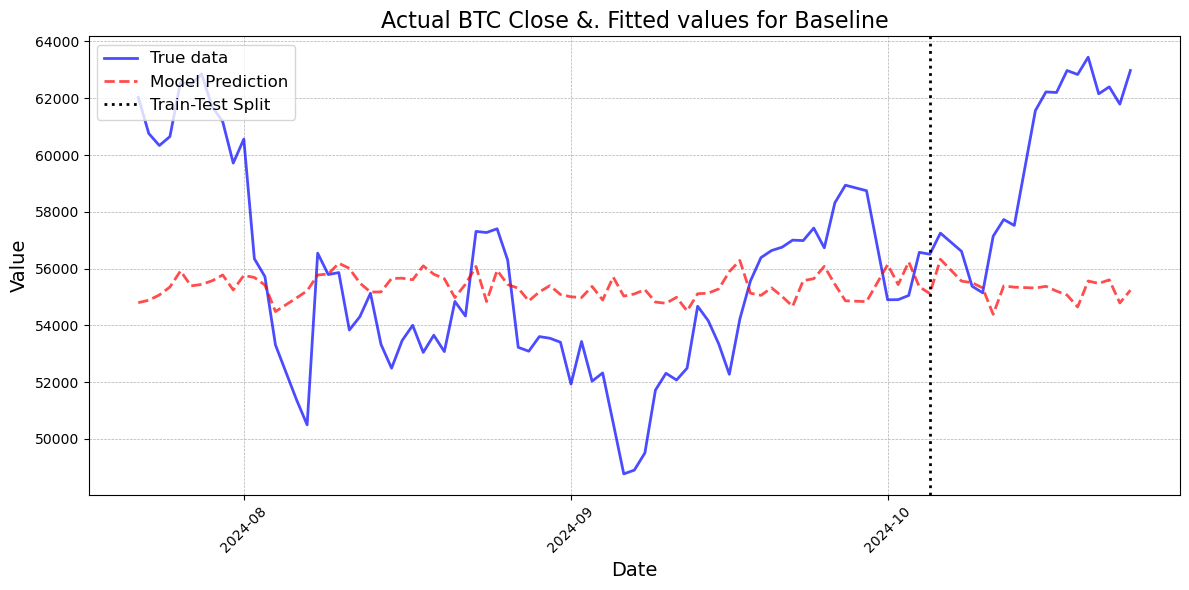

In [214]:
import matplotlib.dates as mdates

split_date = pd.to_datetime(df['date'].iloc[split_index]) 

plt.figure(figsize=(12, 6), dpi=100)

plt.plot(pd.to_datetime(df['date']), y, color='blue', linestyle='-', linewidth=2, label='True data', alpha=0.7)
plt.plot(pd.to_datetime(df['date']), base_model.predict(X), color='red', linestyle='--', linewidth=2, label='Model Prediction', alpha=0.7)
plt.axvline(x=split_date, color='black', linestyle=':', linewidth=2, label='Train-Test Split')

plt.title('Actual BTC Close &. Fitted values for Baseline', fontsize=16)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Adjust the interval for tick marks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend(fontsize=12, loc='upper left')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [209]:
# implement MLP using pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
y_scaler = StandardScaler()
y_train_std = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_std = y_scaler.transform(y_test.values.reshape(-1, 1))

# Convert numpy arrays to torch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
y_train = torch.tensor(y_train_std, dtype=torch.float32).view(-1, 1)  
y_test = torch.tensor(y_test_std, dtype=torch.float32).view(-1, 1)


In [210]:
from mlp_dropout import MLP

# Hyperparameters
input_size = X_train_std.shape[1]  # Number of features
hidden_size1 = 56  # Neurons in the first hidden layer
hidden_size2 = 16  # Neurons in the second hidden layer
output_size = 1  # Single output for regression
learning_rate = 0.0001
num_epochs = 50000  # Consider lowering this initially to avoid long training times

# Initialize model
model = MLP(input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.3)

# define loss and optimizer
criterion = nn.MSELoss()  # MSE
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # adam for smoother optimization path

# train the model
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # compute loss
    outputs = model(X_train_std)
    loss = criterion(outputs, y_train)

    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch+1) % 10000 == 0 or epoch+1==num_epochs:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10000/50000], Loss: 0.4489
Epoch [20000/50000], Loss: 0.2482
Epoch [30000/50000], Loss: 0.1562
Epoch [40000/50000], Loss: 0.1650
Epoch [50000/50000], Loss: 0.1660


In [218]:
# save trained model
model_save_path = "mlp_trained_model.pth"
torch.save(model.state_dict(), model_save_path)

In [211]:
# evaluate the model
X_std = scaler.fit_transform(X)
X_std = torch.tensor(X_std, dtype=torch.float32)


model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # predictions and MSE on training set
    train_predictions = model(X_train_std)
    train_mse = criterion(train_predictions, y_train)
    
    # predictions and MSE on test set
    test_predictions = model(X_test_std)
    test_mse = criterion(test_predictions, y_test)

    yh_all = model(X_std)
    
    # Print MSE results
    print(f'Mean Squared Error on training set: {train_mse.item():.4f}')
    print(f'Mean Squared Error on test set: {test_mse.item():.4f}')

Mean Squared Error on training set: 0.0417
Mean Squared Error on test set: 3.1631


In [212]:
# transform back to original scale
yh_allback = y_scaler.inverse_transform(yh_all.numpy())

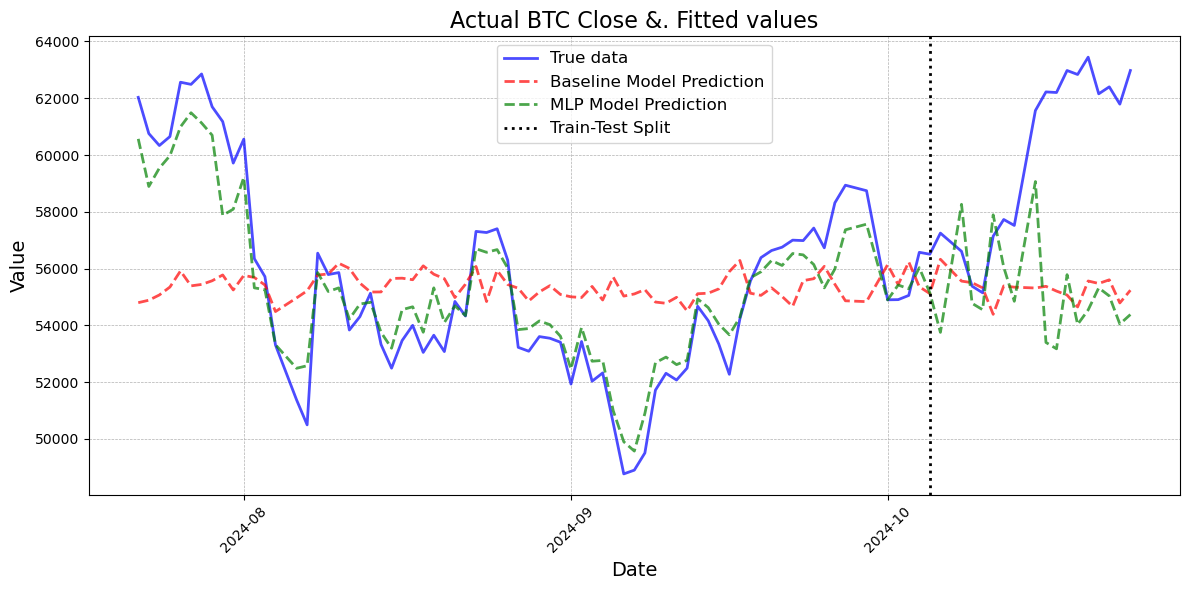

In [219]:

plt.figure(figsize=(12, 6), dpi=100)

plt.plot(pd.to_datetime(df['date']), y, color='blue', linestyle='-', linewidth=2, label='True data', alpha=0.7)
plt.plot(pd.to_datetime(df['date']), base_model.predict(X), color='red', linestyle='--', linewidth=2, label='Baseline Model Prediction', alpha=0.7)
plt.plot(pd.to_datetime(df['date']), yh_allback, color='green', linestyle='--', linewidth=2, label='MLP Model Prediction', alpha=0.7)
plt.axvline(x=split_date, color='black', linestyle=':', linewidth=2, label='Train-Test Split')

plt.title('Actual BTC Close &. Fitted values', fontsize=16)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Adjust the interval for tick marks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend(fontsize=12)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()